In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
cd ..

/home/pierreo


In [96]:
# test the GP cross validation
from problems import get_synthetic_problem
import torch
from search.trust_region import (
    restart,
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from search.utils import eigendecompose_laplacian
from search.models import initialize_model
from scipy.stats import spearmanr
from tqdm._tqdm import tqdm


Experiment to carry out:
- Sample graph
- Take eigendecomposition
- Take a eigenvalue
- Sample nodes
- Reconstruct signals and compare real one with different modes

In [100]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "grid",
        "m": 1,
        "n": n,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

In [90]:
def compute_test_result(base_problem, base_model, prop_data=0.5, mc_samples=5, n_eigenvalue=10):
    r = torch.arange(1,len(base_problem.context_graph), len(base_problem.context_graph) // n_eigenvalue)
    t = torch.zeros(mc_samples, 2, r.shape[0])
    for j_index, j in tqdm(enumerate(r)):
        for i in range(mc_samples):
            all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
            all_Y = base_model.covar_module.base_kernel.eigenbasis[:,j].detach().clone()
            from botorch.utils.transforms import standardize
            n_init = len(all_X)
            X = all_X.reshape(-1, 1).detach().clone()

            # Y = base_problem(X.reshape(-1, 1))
            Y = all_Y.reshape(-1, 1).to(dtype=torch.float).detach().clone()
            Y = standardize(Y)

            best_loc = Y.argmax().item()
            X_best = X[best_loc]

            n_train = int(n_init * prop_data)
            ntrain_indices = np.random.choice(n_init, n_train, replace=False)
            ntest_indices = np.array([i for i in range(n_init) if i not in ntrain_indices])
            X_train, Y_train = X[ntrain_indices, ...], Y[ntrain_indices]
            X_test, Y_test = X[ntest_indices, ...], Y[ntest_indices, ...]
            criterion = torch.nn.MSELoss()

            order = 5
            model_poly, mll_poly, cached_eigenbasis_poly = initialize_model(
                        train_X=X_train,
                        train_Y=Y_train,
                        context_graph=base_problem.context_graph,
                        covar_type="polynomial",
                        covar_kwargs = {
                            "order": order,
                            },
                        fit_model=True,
                        ard=True,
                        use_fixed_noise=False,
                        optim_kwargs = {
                            "train_iters": 500,
                            "lr": 0.1
                        },
                        use_saas_map=False
                        )
            
            model_diff, mll_diff, cached_eigenbasis_diff = initialize_model(
                        train_X=X_train,
                        train_Y=Y_train,
                        context_graph=base_problem.context_graph,
                        covar_type="diffusion",
                        covar_kwargs = {
                            "order": len(base_problem.context_graph.nodes),
                            },
                        fit_model=True,
                        ard=True,
                        use_fixed_noise=False,
                        optim_kwargs = {
                            "train_iters": 500,
                            "lr": 0.1
                        },
                        use_saas_map=False
                        )
            
            model_poly.eval()
            with torch.no_grad():
                # predict on train input
                Y_test_pred = model_poly.posterior(X_test).mean
                error = torch.sqrt(criterion(Y_test_pred, Y_test))
                #mll_poly(Y_test_pred, Y_test)
                t[i, 0, j_index] = error

            model_diff.eval()
            with torch.no_grad():
                # predict on train input
                Y_test_pred = model_diff.posterior(X_test).mean
                error = torch.sqrt(criterion(Y_test_pred, Y_test))
                t[i, 1, j_index] = error
    return t
        

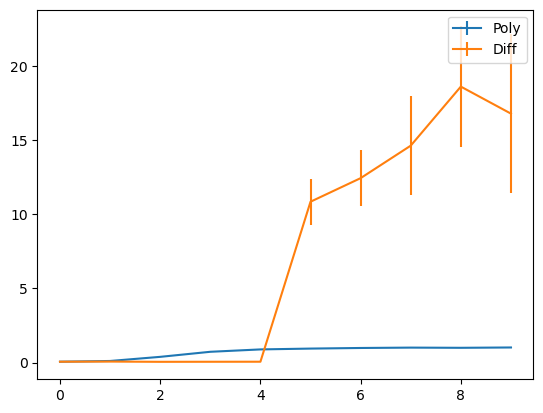

In [94]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "grid",
        "m": 2,
        "n": n,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

result = compute_test_result(base_problem, base_model, mc_samples=10, prop_data=0.5, n_eigenvalue=10)
result_mean_0, result_std_0 = result.mean(dim=0)[0], result.std(dim=0)[0]  
result_mean_1, result_std_1 = result.mean(dim=0)[1], result.std(dim=0)[1]  
plt.errorbar(x = range(result_mean_0.shape[0]), y = result_mean_0, yerr= result_std_0, label="Poly")
plt.errorbar(x = range(result_mean_1.shape[0]), y = result_mean_1, yerr= result_std_1, label="Diff")
plt.legend()

10it [03:26, 20.69s/it]


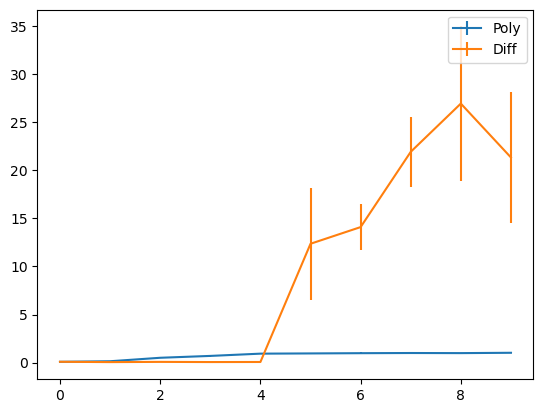

In [95]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "ba",
        "m": 2,
        "n": n,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

result = compute_test_result(base_problem, base_model, mc_samples=10, prop_data=0.5, n_eigenvalue=10)
result_mean_0, result_std_0 = result.mean(dim=0)[0], result.std(dim=0)[0]  
result_mean_1, result_std_1 = result.mean(dim=0)[1], result.std(dim=0)[1]  
plt.errorbar(x = range(result_mean_0.shape[0]), y = result_mean_0, yerr= result_std_0, label="Poly")
plt.errorbar(x = range(result_mean_1.shape[0]), y = result_mean_1, yerr= result_std_1, label="Diff")
plt.legend()

In [86]:
n = 400
base_problem = get_synthetic_problem(
    "test_function", 
    n=n, 
    seed=2,
    problem_kwargs={
        "log": False, 
        "random_graph_type": "ws",
        "m": 2,
        "p": 0.2,
        "k": 4,
        "test_function": "sphere"
        }
    )

X_train = torch.empty(0,1)
Y_train = torch.empty(0,1)
base_model, base_mll, based_cached_eigenbasis = initialize_model(
                train_X=X_train,
                train_Y=Y_train,
                context_graph=base_problem.context_graph,
                covar_type="diffusion",
                covar_kwargs = {
                    "order": 1,
                     },
                fit_model=False,
                ard=True,
                use_fixed_noise=False,
                use_saas_map=False
                )

result = compute_test_result(base_problem, base_model, mc_samples=10, prop_data=0.5, n_eigenvalue=10)
result_mean_0, result_std_0 = result.mean(dim=0)[0], result.std(dim=0)[0]  
result_mean_1, result_std_1 = result.mean(dim=0)[1], result.std(dim=0)[1]  
plt.errorbar(x = range(result_mean_0.shape[0]), y = result_mean_0, yerr= result_std_0, label="Poly")
plt.errorbar(x = range(result_mean_1.shape[0]), y = result_mean_1, yerr= result_std_1, label="Poly")
plt.legend()

0it [15:16, ?it/s]


KeyboardInterrupt: 

In [122]:
all_X = torch.arange(len(base_problem.context_graph)).to(torch.float)
all_Y = base_model.covar_module.base_kernel.eigenbasis[:,300].detach().clone()
from botorch.utils.transforms import standardize
n_init = len(all_X)
X = all_X.reshape(-1, 1).detach().clone()

# Y = base_problem(X.reshape(-1, 1))
Y = all_Y.reshape(-1, 1).to(dtype=torch.float).detach().clone()
Y = standardize(Y)

best_loc = Y.argmax().item()
X_best = X[best_loc]

n_train = int(n_init * 0.5)
ntrain_indices = np.random.choice(n_init, n_train, replace=False)
ntest_indices = np.array([i for i in range(n_init) if i not in ntrain_indices])
X_train, Y_train = X[ntrain_indices, ...], Y[ntrain_indices]
X_test, Y_test = X[ntest_indices, ...], Y[ntest_indices, ...]
criterion = torch.nn.MSELoss()

model_diff, mll_diff, cached_eigenbasis_diff = initialize_model(
            train_X=X_train,
            train_Y=Y_train,
            context_graph=base_problem.context_graph,
            covar_type="diffusion",
            covar_kwargs = {
                "order": len(base_problem.context_graph.nodes),
                },
            fit_model=True,
            ard=True,
            use_fixed_noise=False,
            optim_kwargs = {
                "train_iters": 500,
                "lr": 0.1
            },
            use_saas_map=False
            )

SignificanceResult(statistic=-0.05964526349856547, pvalue=0.40148531008563515)
Loss MSE tensor(203.9790)


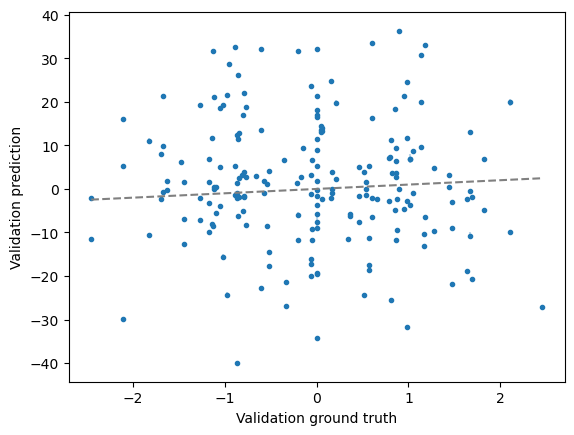

In [123]:
model_diff.eval()
with torch.no_grad():
    # predict on train input
    Y_test_pred = model_diff.posterior(X_test)
    lower, upper = Y_test_pred.mvn.confidence_region()

    Y_test_pred_mean, Y_test_pred_std = Y_test_pred.mean.flatten(), torch.sqrt(Y_test_pred.variance).flatten()
    plt.plot(Y_test, Y_test_pred_mean, ".")
    plt.errorbar(Y_test, Y_test_pred_mean, yerr=Y_test_pred_std, linestyle="None", color="C0", alpha=0.3)
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color="gray", linestyle='--')
    print(spearmanr(Y_test_pred_mean, Y_test))
    plt.xlabel("Validation ground truth")
    plt.ylabel("Validation prediction")
    print("Loss MSE", torch.nn.MSELoss()(Y_test_pred_mean, Y_test))

Text(0.5, 1.0, 'GP training set')

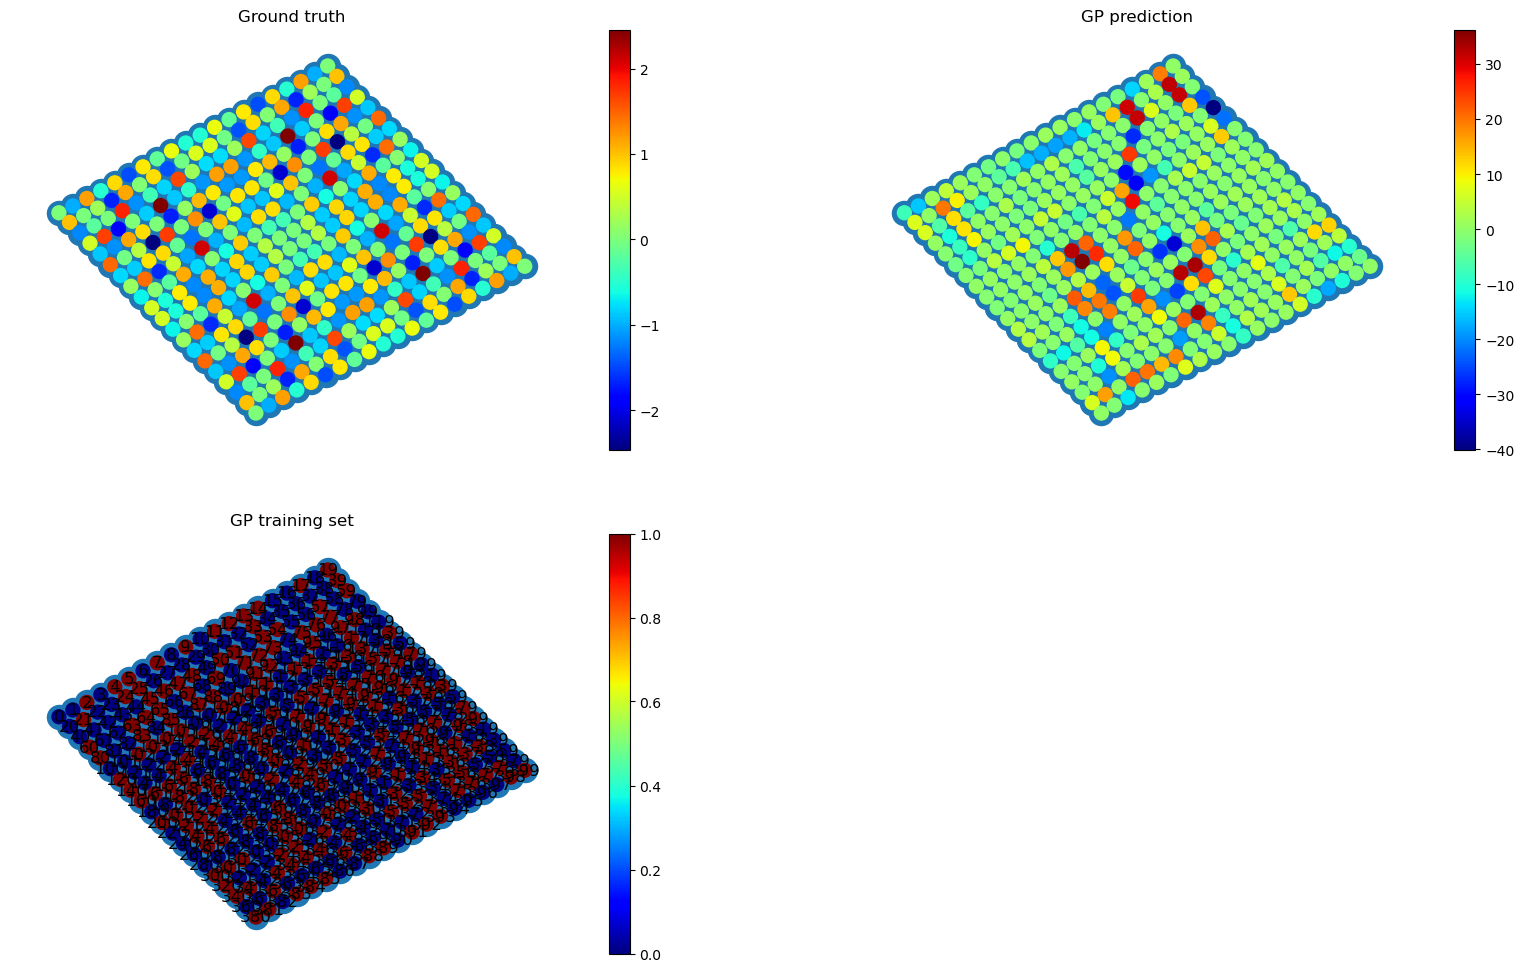

In [124]:
import networkx as nx
pos = nx.kamada_kawai_layout(base_problem.context_graph)
g = base_problem.context_graph
nodes = base_problem.context_graph.nodes()

train_X = X_train.long().flatten().tolist()
test_X = X_test.long().flatten().tolist()
train_Y = [all_Y[i] for i in train_X]
test_Y = [all_Y[i] for i in test_X]
train_pos = {k: pos[k] for k in train_X}
test_pos = {k: pos[k] for k in test_X}

plt.figure(figsize=[20, 12])
plt.subplot(221)
nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
c = nx.draw_networkx_nodes(g, pos, node_color=Y, node_size=100, cmap=plt.cm.jet, linewidths=None, edgecolors=None)

# nc = nx.draw_networkx_nodes(g, train_pos, nodelist=train_X, node_color="gray", node_size=50, cmap=plt.cm.jet, linewidths=0)
# nc = nx.draw_networkx_nodes(g, test_pos, nodelist=test_X, node_color=test_Y, node_size=25, linewidths=0)

plt.colorbar(c)
plt.axis('off')
plt.title("Ground truth")

plt.subplot(222)
with torch.no_grad():
    posterior =  model_diff.posterior(all_X.reshape(-1, 1))
    all_Y_pred =posterior.mean.flatten()
    all_Y_var =torch.sqrt(posterior.variance.flatten())

train_Y_pred = [all_Y_pred[i] for i in train_X]
test_Y_pred = [all_Y_pred[i] for i in test_X]

#colors = all_Y_pred.clip(all_Y.min(), all_Y.max())
colors = all_Y_pred
nx.draw_networkx(base_problem.context_graph, pos, with_labels=False)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, node_color=colors, node_size=100, cmap=plt.cm.jet, linewidths=None)

# nc = nx.draw_networkx_nodes(g, train_pos, nodelist=train_X, node_color="gray", node_size=50, cmap=plt.cm.jet, linewidths=0)
# nc = nx.draw_networkx_nodes(g, test_pos, nodelist=test_X, node_color=test_Y_pred, node_size=25, linewidths=0)
plt.colorbar(nc)
plt.axis('off')
plt.title("GP prediction")

plt.subplot(223)
bin_train = torch.tensor([1 if i in X_train else 0 for i in range(n)])
diff = torch.abs((all_Y_pred.flatten() - all_Y.flatten()) / all_Y.flatten())
# diff.clip_(0, 0.2)
nx.draw_networkx(base_problem.context_graph, pos,with_labels=True)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, node_color=bin_train, node_size=100, cmap=plt.cm.jet,)
plt.colorbar(nc)
plt.axis('off')
plt.title("GP training set")